
最佳旋转角度: 58.16 度
优化后无人机总移动距离: 617.76 单位
局部优化后无人机总移动距离: 617.76 单位

无人机初始位置数组 (x, y):
无人机 1: (164.64, 214.56)
无人机 2: (180.83, 163.46)
无人机 3: (127.10, 193.77)
无人机 4: (131.28, 267.53)
无人机 5: (289.10, 115.03)
无人机 6: (237.52, 158.67)
无人机 7: (170.41, 277.68)
无人机 8: (21.31, 26.14)
无人机 9: (6.07, 249.79)
无人机 10: (233.45, 261.00)
无人机 11: (293.59, 239.75)
无人机 12: (138.44, 234.16)
无人机 13: (35.48, 191.98)
无人机 14: (43.01, 283.40)
无人机 15: (156.55, 124.40)

目标位置数组 (x, y)（优化后）:
无人机 1: (178.43, 179.38)
无人机 2: (204.81, 136.91)
无人机 3: (115.27, 199.02)
无人机 4: (125.68, 264.34)
无人机 5: (267.97, 117.27)
无人机 6: (241.59, 159.75)
无人机 7: (162.46, 287.18)
无人机 8: (78.48, 176.18)
无人机 9: (52.11, 218.65)
无人机 10: (188.84, 244.70)
无人机 11: (215.22, 202.23)
无人机 12: (152.05, 221.86)
无人机 13: (15.32, 195.81)
无人机 14: (88.89, 241.50)
无人机 15: (141.64, 156.54)

各个无人机的移动距离:
无人机 1: 移动距离 = 37.78 单位
无人机 2: 移动距离 = 35.78 单位
无人机 3: 移动距离 = 12.94 单位
无人机 4: 移动距离 = 6.45 单位
无人机 5: 移动距离 = 21.25 单位
无人机 6: 移动距离 = 4.22 单位
无人机 7: 移动距离 = 12.39 单位
无

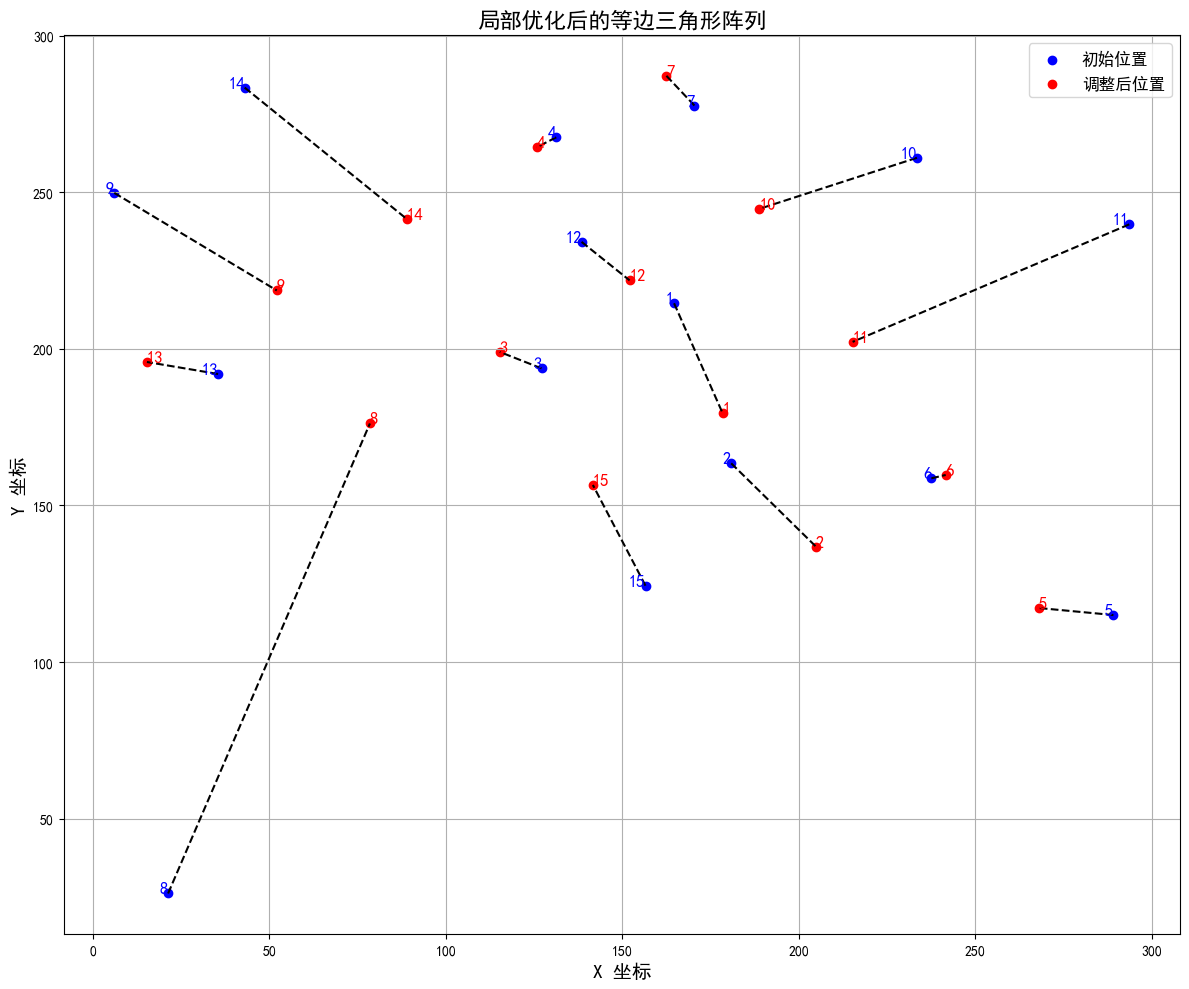

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 随机生成15个初始无人机位置
np.random.seed(0)  # 固定种子以便结果可重复
initial_positions = np.random.rand(15, 2) * 300  # 假设范围在0到300之间

# 等边三角形边长
a = 50  # 边长可以根据实际需求调整

# 构建理想的等边三角形矩阵
triangle_positions = []
for i in range(6):  # 我们有15个点，需要大约6行
    for j in range(i + 1):
        x = j * a
        y = np.sqrt(3) / 2 * a * i
        triangle_positions.append((x, y))
triangle_positions = np.array(triangle_positions[:15])

# 方法1：平移等边三角形阵列，使其质心与无人机初始位置的质心对齐
initial_centroid = np.mean(initial_positions, axis=0)
triangle_centroid = np.mean(triangle_positions, axis=0)
translation_vector = initial_centroid - triangle_centroid
translated_triangle_positions = triangle_positions + translation_vector

# 方法2：旋转等边三角形阵列，以使其更贴近无人机的初始位置
best_angle = 0
min_total_distance = float('inf')
for angle in np.linspace(0, 360, 360):  # 尝试0到360度的旋转
    rotation_matrix = R.from_euler('z', angle, degrees=True).as_matrix()[:2, :2]
    rotated_positions = np.dot(translated_triangle_positions - initial_centroid, rotation_matrix) + initial_centroid

    distance_matrix = np.linalg.norm(initial_positions[:, np.newaxis] - rotated_positions[np.newaxis, :], axis=2)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    total_distance = np.sum(distance_matrix[row_ind, col_ind])

    if total_distance < min_total_distance:
        min_total_distance = total_distance
        best_angle = angle
        best_positions = rotated_positions
        best_row_ind = row_ind
        best_col_ind = col_ind

print(f"\n最佳旋转角度: {best_angle:.2f} 度")
print(f"优化后无人机总移动距离: {min_total_distance:.2f} 单位")

# 局部搜索与交换策略进行进一步优化
def local_search_swap(row_ind, col_ind, distance_matrix):
    best_distance = np.sum(distance_matrix[row_ind, col_ind])
    for i in range(len(row_ind)):
        for j in range(i + 1, len(row_ind)):
            new_col_ind = col_ind.copy()
            # 交换两个匹配
            new_col_ind[i], new_col_ind[j] = new_col_ind[j], new_col_ind[i]
            new_distance = np.sum(distance_matrix[row_ind, new_col_ind])
            if new_distance < best_distance:
                best_distance = new_distance
                col_ind = new_col_ind
    return col_ind, best_distance

# 通过局部搜索和交换优化结果
final_col_ind, final_distance = local_search_swap(best_row_ind, best_col_ind, np.linalg.norm(initial_positions[:, np.newaxis] - best_positions[np.newaxis, :], axis=2))
final_positions = best_positions[final_col_ind]

print(f"局部优化后无人机总移动距离: {final_distance:.2f} 单位\n")

# 打印无人机的初始位置数组和目标位置数组
print("无人机初始位置数组 (x, y):")
for i, pos in enumerate(initial_positions, 1):
    print(f"无人机 {i}: ({pos[0]:.2f}, {pos[1]:.2f})")

print("\n目标位置数组 (x, y)（优化后）:")
for i, pos in enumerate(final_positions, 1):
    print(f"无人机 {i}: ({pos[0]:.2f}, {pos[1]:.2f})")

# 打印各个无人机的移动距离
print("\n各个无人机的移动距离:")
for i in range(len(initial_positions)):
    distance = np.linalg.norm(initial_positions[i] - final_positions[i])
    print(f"无人机 {i+1}: 移动距离 = {distance:.2f} 单位")

# 可视化最终调整过程
plt.figure(figsize=(12, 10))
plt.scatter(initial_positions[:, 0], initial_positions[:, 1], c='blue', label='初始位置')
plt.scatter(final_positions[:, 0], final_positions[:, 1], c='red', label='调整后位置')

# 在图像中添加无人机编号
for i in range(len(initial_positions)):
    plt.text(initial_positions[i, 0], initial_positions[i, 1], str(i+1), fontsize=12, color='blue', ha='right')
    plt.text(final_positions[i, 0], final_positions[i, 1], str(i+1), fontsize=12, color='red', ha='left')

# 绘制调整路径
for i in range(len(initial_positions)):
    plt.plot([initial_positions[i, 0], final_positions[i, 0]],
              [initial_positions[i, 1], final_positions[i, 1]], 'k--')

# 设置图形参数（中文）
plt.xlabel('X 坐标', fontsize=14)
plt.ylabel('Y 坐标', fontsize=14)
plt.title('局部优化后的等边三角形阵列', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# 优化图像展示
plt.tight_layout()
# plt.show()
plt.savefig('two2.png', dpi=300)